Для начала надо получить список постов и для удобства его записать в csv

In [1]:
import requests
import csv
from pandas import DataFrame
import pandas as pd
import time
import matplotlib.pyplot as plt


https://oauth.vk.com/authorize?client_id=5453402&display=page&redirect_uri=http://localhost&scope=offline&response_type=token&v=5.80

In [2]:
token = '255c7eb6083fd96e2954a9a85d08bd6400c780912774f6d820150e6c9b8652a60a0458ddf8884c6e2a44b'

In [52]:
def get_wall(owner_id, offset): #функция для получения 2500 постов
    try:    
        wall_data = requests.post('https://api.vk.com/method/execute.Shmakov_wallGet',
                                  params={'owner_id':owner_id,
                                          'post_count':2500,
                                          'offset':offset,
                                          'v':'5.80',
                                          'func_v':'3',
                                          'access_token':token}).json()
        
        
        return wall_data['response']
    except Exception as e:
        print('ERROR- ошибка в получении постов из ВК',e)
        
def parse_wall_data(wall_data): #функция для преобразования данных о постах в датафрейм
    wall = wall_data[1]
    post_count = wall_data[0]

    list_post_id = []
    list_post_date = []
    list_count_likes = []
    list_count_repost = []
    list_count_comments = []
    list_count_views = []
    list_poll_id = []
    list_poll_votes = []

    for post in wall:
        post_id = post['id']
        post_date = post['date']
        post_likes = post['likes']['count']
        post_repost = post['reposts']['count']
        post_comments = post['comments']['count']
        
        if post.get('views') == None:
            post_views = 0
        else:
            post_views = post['views']['count']
        
        poll_id = 0
        poll_votes = 0
        
        #В постах ищем прикрепление типа "опрос",
        #если находим, то берем данные и добавляем в два списка, для последующего экспорта в словарь
        try:
            for attachment in post['attachments']:
                try:
                    poll_id = attachment['poll']['id']
                    poll_votes = attachment['poll']['votes']
                except:
                    pass
        except Exception as e:
            print('Нет прикреплений медиаобъектов',e, post_id)
                
        
        #добавляем в список элементы
        list_post_id.append(post_id)
        list_post_date.append(post_date)
        list_count_likes.append(post_likes)
        list_count_repost.append(post_repost)
        list_count_comments.append(post_comments)
        list_count_views.append(post_views)
        list_poll_id.append(poll_id)
        list_poll_votes.append(poll_votes)
        
        #print(post_id , post_date)

    #на выходе создаем словарь, ...
    data = {'owner_id':owner_id,
            'date':list_post_date,
            'post_id':list_post_id,
            'count_likes':list_count_likes,
            'count_repost':list_count_repost,
            'count_comments':list_count_comments,
            'count_views':list_count_views,
            'poll_id':list_poll_id,
            'count_votes':list_poll_votes}
    
    #из словаря создаем датафрейм
    post_frame = pd.DataFrame.from_dict(data, orient='columns', dtype=None, columns=None)
    return post_frame

def get_comments(owner_id, post_id): #функция для получения 2500 комментариев
    try:

        comments = requests.post('https://api.vk.com/method/execute.wall_getComments?owner_id='+
                          str(owner_id)+'&post_id='+str(post_id)+'&v=5.80&access_token='+token).json()
        
        time.sleep(.34)
        return comments['response']
        
    except Exception as e:
        print('ERROR- ошибка в получении комментариев',e, post_id) 
    

def parse_comments(comments): #функция для преобразования данных о комментариях в датафрейм
    type_obj = 3

    list_date = []
    list_user_id = []
    list_count_likes = []
    
    try:
        for comment in comments:
            comment_user_id = comment['from_id'] # автор комментария
            comment_id = comment['id']   # ID комментария
            comment_text = comment['text']
            comment_date = comment['date']
            comment_like_count = comment['likes']['count']

            list_date.append(comment_date)
            list_user_id.append(comment_user_id)
            list_count_likes.append(comment_like_count)

            #print(comment_user_id,comment_date,comment_like_count  )

            data = {'owner_id':owner_id,
                    'type':3, #лайк - 1, репост - 2, комментарий - 3
                    'date':list_date,
                    'post_id':post_id,
                    'obj_id':comment_id,
                    'user_id':list_user_id,
                    'count_likes':list_count_likes}

        frame = pd.DataFrame.from_dict(data, orient='columns', dtype=None, columns=None)
        frame['date'] = pd.to_datetime(frame['date'],unit='s')

        return frame
    except Exception as e:
        print('ERROR - ошибка в парсинге комментов',e, post_id)

#функция для получения списка ID Юзеров, которые поставили лайк
def get_like_list(owner_id, post_id, type_obj, offset): #функция для получения 2500 постов
    try:   
        like_data = requests.post('https://api.vk.com/method/execute.Shmakov_get_object_activity',
                                  params = {'owner_id':owner_id,
                                           'post_id':post_id,
                                            'offset':offset,
                                            'type_obj':type_obj,
                                            'access_token': token,
                                            'v':'5.80'
                                           }
                                  ).json()      
        time.sleep(.34)
        like_count = like_data['response'][0]
        likes_list = like_data['response'][1]  
        
        if like_count > offset:
            offset = offset + 25000
            #print(offset)
            data = get_like_list(owner_id, post_id, type_obj, offset)
            like_count = data[0]
            likes_list = likes_list + data[1]
            return like_count, likes_list
        else:
        
            return like_count, likes_list
  
    except Exception as e:
        print('ERROR - в сборе лайков',e , post_id )
        
def parse_likes(owner_id, post_id, type_obj, offset):
    try:
        likes_data = get_like_list(owner_id, post_id, type_obj, offset)
        like_count = likes_data[0]
        likes_list = likes_data[1]

        data = {'owner_id':owner_id,
                'type':1, #лайк - 1, репост - 2, комментарий - 3
                'date':post_date,
                'post_id':post_id,
                'obj_id':0,
                'user_id':likes_list,
                'count_likes':0}
        frame = pd.DataFrame.from_dict(data, orient='columns', dtype=None, columns=None)

        return frame
    except Exception as e:
        print('ERROR -ошибка в парсинге лайков',e, post_id)

# Шаг 1 - Получить данные о 2500 постах
    

In [ ]:
owner_id = -38369814 #id сообщества с минусом
offset = 0 #начальное смещение
wall_data = get_wall(owner_id, offset)
post_frame = parse_wall_data(wall_data)
post_frame['date'] = pd.to_datetime(post_frame['date'],unit='s')


# Шаг 2 - Экспресс-анализ постов


In [55]:
post_frame.head()

owner_id                date  post_id  count_likes  count_repost  \
0 -38369814 2018-02-16 07:19:19    22423           50            19   
1 -38369814 2018-06-28 07:25:59    22718            6             0   
2 -38369814 2018-06-23 23:21:17    22713           11             6   
3 -38369814 2018-06-18 12:45:44    22701           18             8   
4 -38369814 2018-06-14 21:23:28    22698            6             0   

   count_comments  count_views  poll_id  count_votes  
0               1         7547        0            0  
1               0          600        0            0  
2               0         1083        0            0  
3               8         2730        0            0  
4               2         3017        0            0

In [63]:
frame_params = post_frame.loc[:,['date','count_likes','count_repost','count_comments','count_views']]

Расчитаем 2 дополнительных показателя:
- **ERpost** = сумма(лайки+репосты+комментарии) / количество подписчиков*
- **ERview** = сумма(лайки+репосты+комментарии) / количество просмотров

* Количество подписчиков берется из паблика. Стоит учитывать, что для точности расчета нужно знать количество подписчиков в каждый день. Если брать текущие значение из паблика, то не рекмендую сравнивать период старше 3х месяцев (исключение - если известно, что в данный период не было резкиз скачков и паблик медленно рос)

In [64]:
frame_params['ERpost'] = (frame_params['count_likes'] + frame_params['count_repost']+frame_params['count_comments'])/33000
frame_params['ERview'] = (frame_params['count_likes'] + frame_params['count_repost']+frame_params['count_comments'])/frame_params['count_views'] 

Построим таблицу по сумме показателей по месяцам, чтобы было видно как меняются показетил по месяцам.

In [65]:
frame_params = frame_params.set_index('date').groupby(pd.TimeGrouper('M')).sum().sort_values(by=['date'],  ascending=False)
frame_params

D:\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  """Entry point for launching an IPython kernel.


count_likes  count_repost  count_comments  count_views    ERpost  \
date                                                                           
2018-06-30           63            17              18        14741  0.002970   
2018-05-31           59            14              15        14352  0.002667   
2018-04-30           20             0              15        11845  0.001061   
2018-03-31          192            45              15        44753  0.007636   
2018-02-28          199            43              44        56461  0.008667   
2018-01-31          190            16              45        47601  0.007606   
2017-12-31          155            26              26        30198  0.006273   
2017-11-30          156            43              16        24260  0.006515   
2017-10-31           46            14              13         8922  0.002212   
2017-09-30           87             7              27        20151  0.003667   
2017-08-31          326            32              16        25296  0.011333   
2017-07-31          206            18              28        16960  0.007636   
2017-06-30          156             4              20         9453  0.005455   
2017-05-31          498            55              54        51605  0.018394   
2017-04-30          156            29              18        19311  0.006152   
2017-03-31          227            49              45        36628  0.009727   
2017-02-28           92            24              12        23245  0.003879   
2017-01-31          326            45              69        56400  0.013333   
2016-12-31          332            78              23            0  0.013121   
2016-11-30          432           124              66            0  0.018848   
2016-10-31          425            98              71            0  0.018000   
2016-09-30          911           226              92            0  0.037242   
2016-08-31          549           150             102            0  0.024273   
2016-07-31          389           101             202            0  0.020970   
2016-06-30          402            98              86            0  0.017758   
2016-05-31          852           204              95            0  0.034879   
2016-04-30          924           253             181            0  0.041152   
2016-03-31          839           216              61            0  0.033818   
2016-02-29          315            88              35            0  0.013273   
2016-01-31          224           100              27            0  0.010636   
...                 ...           ...             ...          ...       ...   
2015-01-31         1526           352             395            0  0.068879   
2014-12-31          782           161             409            0  0.040970   
2014-11-30         1209           294             301            0  0.054667   
2014-10-31         1055           284             428            0  0.053545   
2014-09-30          555           149             191            0  0.027121   
2014-08-31          500           123              97            0  0.021818   
2014-07-31          223            53             117            0  0.011909   
2014-06-30         2506           709             699            0  0.118606   
2014-05-31         2111           592             702            0  0.103182   
2014-04-30         2588           678             998            0  0.129212   
2014-03-31         3652           810            1016            0  0.166000   
2014-02-28         2992           701            1072            0  0.144394   
2014-01-31          842           132             735            0  0.051788   
2013-12-31          714           191             264            0  0.035424   
2013-11-30          175            42             213            0  0.013030   
2013-10-31           35             7              12            0  0.001636   
2013-09-30           92            25              14            0  0.003970   
2013-08-31  

Записываем данные о постах если нужно

In [51]:
post_frame.to_csv('данные о постах.csv')
frame_params.to_csv('показатели по месяцам.csv')

# Шаг 2 - Для каждого ID поста запросить ID пользователей лайков и комментариев


- время для лайков берется как время поста
- время для комментариев - время публикации комментария

In [66]:
%%time
frame = pd.DataFrame()

post_frame_date = post_frame[post_frame['date'] >= '2018-01-29' ] # надо поменять дату, до какой делать сбор

for i in range (0,len(post_frame_date['post_id']) ): #len(post_frame['post_id'])
    
    post_date = post_frame_date['date'][i]
    post_id = post_frame_date['post_id'][i]
    
    owner_id = post_frame_date['owner_id'][i]
    
    if post_frame_date['count_comments'][i] > 0:
        #собираем всех комментаторов
        comments = get_comments(owner_id, post_id)
        frame = frame.append(parse_comments(comments))
    
        #собираем всех лайковших
        frame = frame.append(parse_likes(owner_id, post_id, 'post', 0))
    else:
        pass

    #собираем всех лайковших
    frame = frame.append(parse_likes(owner_id, post_id, 'post', 0))
frame = frame.drop_duplicates() #по какой-то причине задваиваются лайки, поэтому удаление дублей


Wall time: 1min 31s


Если нужно, то записываем активную аудиорию

In [16]:
frame.to_csv('активная аудитория.сsv')

In [67]:
frame.head()

owner_id  type                date  post_id  obj_id      user_id  \
0 -38369814     3 2018-04-17 09:27:37    22423   22598     928041.0   
0 -38369814     1 2018-02-16 07:19:19    22423       0  154018195.0   
1 -38369814     1 2018-02-16 07:19:19    22423       0  300105773.0   
2 -38369814     1 2018-02-16 07:19:19    22423       0      53327.0   
3 -38369814     1 2018-02-16 07:19:19    22423       0     230683.0   

   count_likes  
0            0  
0            0  
1            0  
2            0  
3            0

Сгруппируем по *user_id*, чтобы узнать кто сколько действий сделал.

In [68]:
user_activity = frame.groupby('user_id').count()
user_activity.sort_values(by=['owner_id'],  ascending=False).head()

owner_id  type  date  post_id  obj_id  count_likes
user_id                                                       
928041.0          40    40    40       40      40           40
5649643.0         23    23    23       23      23           23
355658.0          17    17    17       17      17           17
24509607.0        16    16    16       16      16           16
5832008.0         13    13    13       13      13           13

Узнаем распределение по частоте действий.
Слева столбец owner_id = количество действий. 

In [69]:
count = user_activity.groupby('owner_id').count()['type']
count

owner_id
1     318
2      48
3      12
4       9
5       2
6       3
8       2
9       2
12      1
13      2
16      1
17      1
23      1
40      1
Name: type, dtype: int64

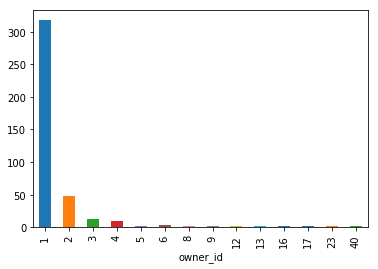

In [70]:
count.plot('bar')